# Model code

This notebook holds the code for running the various models and includes some of the plots and results from the paper

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm 
import warnings

warnings.simplefilter(action="ignore", category=tqdm.TqdmExperimentalWarning)
warnings.simplefilter(action="ignore", category=pd.core.common.SettingWithCopyWarning)

from tqdm.autonotebook import tqdm

%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)


In [2]:
from model.laplacian import Laplacian
from model.features import Features
from model.targets import Targets
from model.regression.basic import LinearRegression, LassoRegression, RidgeRegression, NaiveRegression
from model.regression.glskgr import GLSKGR, GraphFeaturesGLSKGR
from model.regression.kgr import KGR, GraphFeaturesKGR

from model.utils import diag_i, make_ST

## 1. Example model for plotting

In [7]:
# initialise a model
laplacian = Laplacian()
features = Features(transform='log')
target = Targets('Ozone', transform='log')

model_kgr = KGR(gamma= 0.0037, K_std=20, filter_func='sigmoid', beta=62).set_laplacian(laplacian).set_data(features, target)

# run the optimisation routine to find the best parameters
model_kgr.optimize()

# calculate the posterior variance
model_kgr.set_Fvar()

<IPython.core.display.Javascript object>


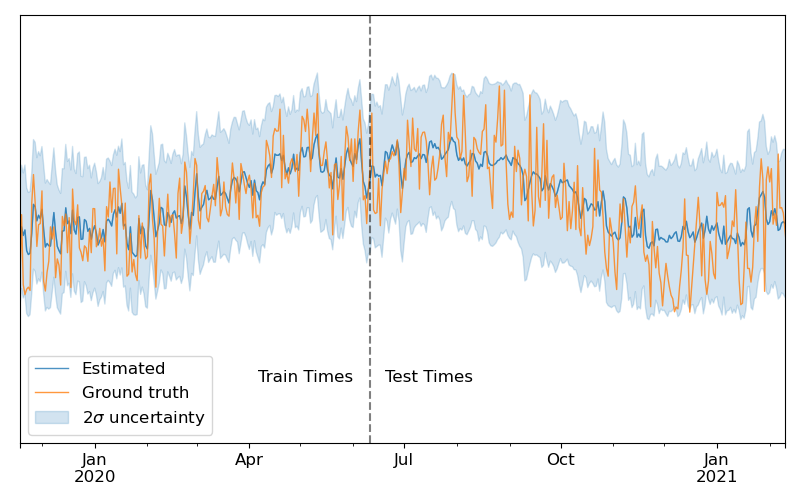

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

site = '16_1_10'

x = model_kgr.F.columns

y_pred = model_kgr.F.loc[site]
y_obs = model_kgr.targets.Y0.loc[site]
y_unc = model_kgr.Fvar.loc[site] ** 0.5


y_pred.plot(lw=1, label='Estimated',  ax=ax, alpha=0.8)

y_obs.plot(lw=1, label='Ground truth',  ax=ax, alpha=0.8)

ax.fill_between(x, y_pred, y_pred + 2 * y_unc, alpha=0.2, color='tab:blue', label='2$\sigma$ uncertainty', zorder=-1)
ax.fill_between(x, y_pred, y_pred - 2 * y_unc, alpha=0.2, color='tab:blue', zorder=-1)


ax.set_yticks([])



ax.legend(loc='lower left', fontsize='large')


ax.set_xlim(x[1050], x[1500])
ax.set_ylim(-4.5, 2.5)

ax.axvline(x[1256], color='k', alpha=0.5, ls='--')

ax.text(x[1265], -3.5,  'Test Times', fontsize='large')
ax.text(x[1190], -3.5,  'Train Times', fontsize='large')


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize('large')
    
plt.tight_layout()


# plt.savefig('prediction-time-series.pdf')

<IPython.core.display.Javascript object>


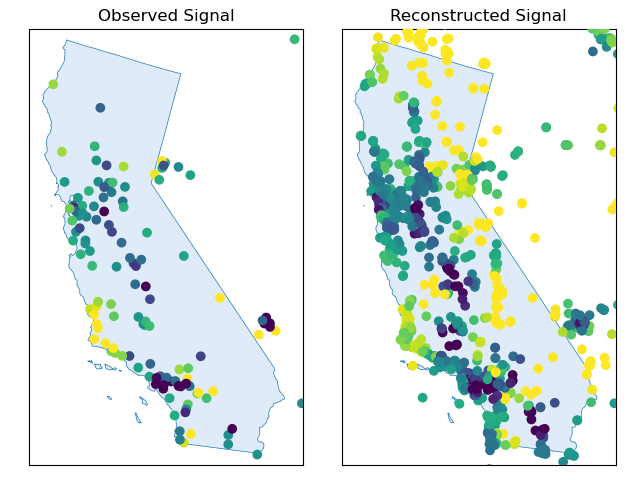

In [11]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

ti = 6
t = model_kgr.targets.Y.columns[ti]

laplacian.distance.cali.plot_outline(axes[1], dict(color='tab:blue'), fill={'fc': '#e0ebf9', 'lw': 0.5, 'ec': 'tab:blue'})
laplacian.distance.cali.plot_outline(axes[0], dict(color='tab:blue'), fill={'fc': '#e0ebf9', 'lw': 0.5, 'ec': 'tab:blue'})

vmin = np.quantile(model_kgr.targets.Y.loc[:, t], 0.1)
vmax = np.quantile(model_kgr.targets.Y.loc[:, t], 0.9)

axes[1].scatter(model_kgr.targets.sites['x'], model_kgr.targets.sites['y'], c=model_kgr.F.loc[:, t], alpha=1, vmin=vmin, vmax=vmax, zorder=np.inf)

axes[0].scatter(model_kgr.targets.sites.loc[model_kgr.targets.train_sites, 'x'], model_kgr.targets.sites.loc[model_kgr.targets.train_sites, 'y'], c=model_kgr.targets.Y.loc[:, t], alpha=1, vmin=vmin, vmax=vmax, zorder=np.inf)

axes[0].set_title('Observed Signal')
axes[1].set_title('Reconstructed Signal')

plt.tight_layout()

# plt.savefig('reconstructed.pdf')




## 2. Generate paper results

In [35]:
def get_results(transform='log'):
    """
    This function runs through all the different pollutants and models, optimises their
    parameters, and reports the aaccuracy. This takes some time to run. Input a transform
    type as one of 'log', 'norm', 'quantile' or None
    """
    
    metrics = ['Ozone', 'SO2', 'CO', 'NO2', 'PM25', 'PM10']
    features = Features(transform='log')
    targets = {metric: Targets(metric, transform='log') for metric in metrics}
    
    
    models = {
              'KGR': KGR, 
              'KGR (GF)': GraphFeaturesKGR, 
              'GLSKGR': GLSKGR,
              'GLSKGR (GF)': GraphFeaturesGLSKGR,
              'LinearRegression': LinearRegression, 
              'RidgeRegression': RidgeRegression, 
              'LassoRegression': LassoRegression
             }

    init_params = {'KGR': dict(gamma=0.01, K_std=50, filter_func='sigmoid', beta=50), 
                   'KGR (GF)':  dict(gamma=0.01, beta=10, beta_f=10, filter_func='sigmoid'),
                   'LinearRegression': dict(fit_intercept=True), 
                   'RidgeRegression': dict(fit_intercept=True, alpha=50),
                   'LassoRegression': dict(fit_intercept=True, alpha=1)}


    opt_params = {metric: {model: {} for model in models.keys()} for metric in metrics}

    RMSE = {'Missing Nodes':  {model: {} for model in models.keys()}, 
            'Labelled':       {model: {} for model in models.keys()}, 
            'Missing Dates':  {model: {} for model in models.keys()}, 
            'All Unlabelled': {model: {} for model in models.keys()}}
    
    metrics_bar = tqdm(metrics[0:1], leave=False)

    for metric in metrics_bar:
        
        continue

        metrics_bar.set_description(metric)

        models_bar = tqdm(models, leave=False)

        for model in models_bar:

            models_bar.set_description(model)

            if model != 'GLSKGR' and model != 'GLSKGR (GF)':
                reg = models[model](**init_params[model])

                if model != 'KGR' and model != 'KGR (GF)':
                    opt_params[metric][model] = reg.set_data(features, targets[metric]).optimize()[0]

                else:
                    opt_params[metric][model] = reg.set_laplacian(laplacian).set_data(features, targets[metric]).optimize()[0]

            else:
                
                if model == 'GLSKGR':
                    reg = models['GLSKGR'](**opt_params[metric]['KGR']).set_laplacian(laplacian).set_data(features, targets[metric])
                    opt_params[metric]['GLSKGR'] = opt_params[metric]['KGR']
                    reg.solve_GLS()
                else:
                    reg = models['GLSKGR (GF)'](**opt_params[metric]['KGR (GF)']).set_laplacian(laplacian).set_data(features, targets[metric])
                    opt_params[metric]['GLSKGR (GF)'] = opt_params[metric]['KGR (GF)']
                    reg.solve_GLS()
                                        
            RMSE['Missing Nodes'][model][metric] = reg.RMSE_missing_nodes()
            RMSE['Labelled'][model][metric] = reg.RMSE_labelled()
            RMSE['Missing Dates'][model][metric] = reg.RMSE_missing_times()
            RMSE['All Unlabelled'][model][metric] = reg.RMSE_unlabelled_full()
            
    return opt_params, RMSE
            

In [36]:
opt_params, RMSE = get_results(transform='log')

  0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
pd.DataFrame(RMSE['All Unlabelled']).T.drop('SO2', axis=1)

,Ozone,CO,NO2,PM2.5,PM10
GLS KGR,0.6444,0.8207,0.6912,0.7512,0.6899
KGR,0.6539,0.8438,0.7201,0.7809,0.6728
GLS KGR (GF),0.6835,0.8602,0.7392,0.7859,0.7008
KGR (GF),0.6706,0.8685,0.7703,0.8003,0.6957
Ridge,0.7298,0.9704,0.7316,0.7819,0.7195
Lasso,0.7283,0.9881,0.7296,0.7763,0.7222
OLS,1.1276,2.4638,1.0311,1.1715,1.1784
